In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def fileList(path_before):
    file_list = os.listdir(path_before)
    names = []
    for file in file_list:
        names.append(file)
    names.sort()
    return names


In [40]:
# good = []
# good_label = []
# bad = []
# bad_label = []

# for type in fileList('MVTec_grid'):
#     if type == 'good':
#         for name in fileList('MVTec_grid/good'):
#             good.append(plt.imread('MVTec_grid/good/'+name))
#             good_label.append(0)

#     else:
#         for name in fileList('MVTec_grid/' + type):
#             bad.append(plt.imread('MVTec_grid/'+type+'/'+name))
#             bad_label.append(1)

# good_original = good
# bad_original = bad

# good = np.array(good)
# bad = np.array(bad)

In [24]:
X = []
y = []
category = []
height = 100
width = 100

for type in fileList('MVTec_grid'):
    for name in fileList('MVTec_grid/'+type):
        image = plt.imread('MVTec_grid/'+type+'/'+name)
        X.append(cv2.resize(image, (height, width)))
        y.append(int(type != 'good'))
        category.append(type)

X = np.array(X)
X = np.expand_dims(X, axis=-1)
y = np.array(y)

In [25]:
print(X.shape)
print(y.shape)

(321, 100, 100, 1)
(321,)


In [26]:
# # good 레이블들을 numpy 배열로 변환
# good_label = np.zeros(len(good), dtype=int)
# # bad 레이블들을 numpy 배열로 변환
# bad_label = np.ones(len(bad), dtype=int)

# # 모든 이미지들을 하나로 합치기
# all_images = np.concatenate((good, bad), axis=0)

# # 모든 레이블들을 하나로 합치기
# all_labels = np.concatenate((good_label, bad_label), axis=0)

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=category, random_state=0)

In [30]:
print(x_train.shape)
print(y_train.shape)

(256, 100, 100, 1)
(256,)


- 채널차원
- 트레인 테스트 골고루 해야 함(bent, glue..)

In [36]:
from tensorflow.keras import layers, Model

channels = 1

inputs = layers.Input(shape=(height, width, channels))

# Body
x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
x = layers.MaxPooling2D((2, 2), strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.MaxPooling2D((2, 2), strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.MaxPooling2D((2, 2), strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# Neck
x = layers.GlobalMaxPooling2D()(x)

# Header
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Ba  (None, 50, 50, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_10 (Activation)  (None, 50, 50, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 64)        1849

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=16, epochs=300, callbacks=[es_callback])

Epoch 1/300
13/13 [==============================] - 3s 106ms/step - loss: 0.9037 - acc: 0.4363 - val_loss: 0.7019 - val_acc: 0.2308
Epoch 2/300
13/13 [==============================] - 1s 91ms/step - loss: 0.7580 - acc: 0.5343 - val_loss: 0.6942 - val_acc: 0.2308
Epoch 3/300
13/13 [==============================] - 1s 91ms/step - loss: 0.6621 - acc: 0.5490 - val_loss: 0.6751 - val_acc: 0.7692
Epoch 4/300
13/13 [==============================] - 1s 91ms/step - loss: 0.5824 - acc: 0.6814 - val_loss: 0.6517 - val_acc: 0.7692
Epoch 5/300
13/13 [==============================] - 1s 92ms/step - loss: 0.5131 - acc: 0.7500 - val_loss: 0.6208 - val_acc: 0.7692
Epoch 6/300
13/13 [==============================] - 1s 93ms/step - loss: 0.5009 - acc: 0.7647 - val_loss: 0.5890 - val_acc: 0.7692
Epoch 7/300
13/13 [==============================] - 1s 93ms/step - loss: 0.4208 - acc: 0.8382 - val_loss: 0.5667 - val_acc: 0.7692
Epoch 8/300
13/13 [==============================] - 1s 92ms/step - loss: 0

In [38]:
p_test = model.predict(x_test)
p_test

3/3 [==============================] - 0s 24ms/step


array([[0.24104387],
       [0.2395902 ],
       [0.24059659],
       [0.24008238],
       [0.24018504],
       [0.24056123],
       [0.24030691],
       [0.24071449],
       [0.24073188],
       [0.23967738],
       [0.24000993],
       [0.23998463],
       [0.2402317 ],
       [0.2404245 ],
       [0.24057415],
       [0.24065433],
       [0.24082202],
       [0.23986836],
       [0.24019594],
       [0.2406268 ],
       [0.24131688],
       [0.24074352],
       [0.23965672],
       [0.24007499],
       [0.24050726],
       [0.23996074],
       [0.24098234],
       [0.24030568],
       [0.2404723 ],
       [0.240211  ],
       [0.24062353],
       [0.23945114],
       [0.23959652],
       [0.24016272],
       [0.24069653],
       [0.23982552],
       [0.24036668],
       [0.24085087],
       [0.24042399],
       [0.24052997],
       [0.24041092],
       [0.24059492],
       [0.24104804],
       [0.2402294 ],
       [0.24023812],
       [0.24010597],
       [0.2407484 ],
       [0.239

정확도 : 0.8307692307692308
f1 : 0.0


<Figure size 640x480 with 0 Axes>

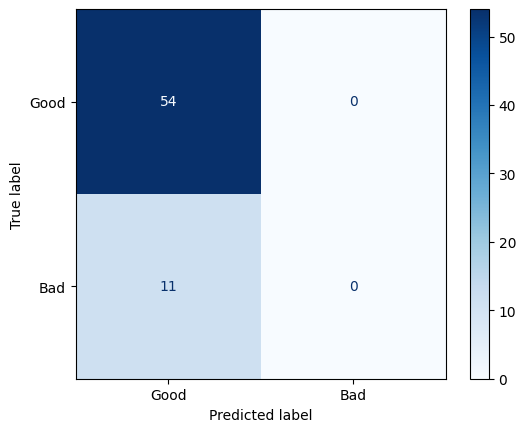

In [39]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

p_test_bin = p_test>=0.5

print('정확도 :', accuracy_score(y_test, p_test_bin))
print('f1 :', f1_score(y_test, p_test_bin))

plt.figure()
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, p_test_bin), display_labels=['Good', 'Bad']).plot(cmap='Blues')
plt.show()
